In [1]:
%cd '/content/drive/MyDrive/Training AI/NLP Tutorial/Question Answering'

/content/drive/MyDrive/Training AI/NLP Tutorial/Question Answering


#Import Libraries

In [2]:
import re
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Embedding, LSTM, Input, Bidirectional, Concatenate
from tensorflow.keras.layers import AdditiveAttention

#Open dataset


In [3]:
line_path = "/content/drive/MyDrive/Training AI/NLP Tutorial/Question Answering/datasets/archive/cornell movie-dialogs corpus/movie_lines.txt"
conver_path = "/content/drive/MyDrive/Training AI/NLP Tutorial/Question Answering/datasets/archive/cornell movie-dialogs corpus/movie_conversations.txt"

In [4]:
lines = open(line_path, encoding='utf-8',
             errors='ignore').read().split('\n')

convers = open(conver_path, encoding='utf-8',
             errors='ignore').read().split('\n')

In [5]:
lines[:10]

['L1045 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ They do not!',
 'L1044 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ They do to!',
 'L985 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ I hope so.',
 'L984 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ She okay?',
 "L925 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ Let's go.",
 'L924 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ Wow',
 "L872 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ Okay -- you're gonna need to learn how to lie.",
 'L871 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ No',
 'L870 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ I\'m kidding.  You know how sometimes you just become this "persona"?  And you don\'t know how to quit?',
 'L869 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ Like my fear of wearing pastels?']

In [6]:
print(len(lines))
print(len(convers))

304714
83098


#Preprocessing

In [7]:
convers[0].split(' +++$+++ ')[-1][1:-1].replace("'", '').replace(",","").split()

['L194', 'L195', 'L196', 'L197']

In [8]:
lines[0].split(' +++$+++ ')[-1].replace("'", '')

'They do not!'

In [9]:
exchn = []
for conver in convers:
    exchn.append(conver.split(' +++$+++ ')[-1][1:-1].replace("'", " ").replace(",","").split())


In [10]:
exchn[:10]

[['L194', 'L195', 'L196', 'L197'],
 ['L198', 'L199'],
 ['L200', 'L201', 'L202', 'L203'],
 ['L204', 'L205', 'L206'],
 ['L207', 'L208'],
 ['L271', 'L272', 'L273', 'L274', 'L275'],
 ['L276', 'L277'],
 ['L280', 'L281'],
 ['L363', 'L364'],
 ['L365', 'L366']]

In [11]:
diag = {}
for line in lines:
    diag[line.split(' +++$+++ ')[0]] = line.split(' +++$+++ ')[-1]

In [17]:
dict(list(diag.items())[0:10])

{'L1044': 'They do to!',
 'L1045': 'They do not!',
 'L869': 'Like my fear of wearing pastels?',
 'L870': 'I\'m kidding.  You know how sometimes you just become this "persona"?  And you don\'t know how to quit?',
 'L871': 'No',
 'L872': "Okay -- you're gonna need to learn how to lie.",
 'L924': 'Wow',
 'L925': "Let's go.",
 'L984': 'She okay?',
 'L985': 'I hope so.'}

In [18]:
del(lines, convers, conver, line)

In [19]:
questions = []
answers = []

for conver in exchn:
    for i in range(len(conver) - 1):
        questions.append(diag[conver[i]])
        answers.append(diag[conver[i+1]])

In [20]:
len_seq = 13

In [21]:
del(diag, exchn, conver, i)

In [22]:
sorted_ques = []
sorted_ans = []
for i in range(len(questions)):
    if len(questions[i]) < len_seq:
        # print(questions[i])
        sorted_ques.append(questions[i])
        sorted_ans.append(answers[i])

In [23]:
def clean_text(txt):
    txt = txt.lower()
    txt = re.sub(r"i'm", "i am", txt)
    txt = re.sub(r"he's", "he is", txt)
    txt = re.sub(r"she's", "she is", txt)
    txt = re.sub(r"that's", "that is", txt)
    txt = re.sub(r"what's", "what is", txt)
    txt = re.sub(r"where's", "where is", txt)
    txt = re.sub(r"\'ll", " will", txt)
    txt = re.sub(r"\'ve", " have", txt)
    txt = re.sub(r"\'re", " are", txt)
    txt = re.sub(r"\'d", " would", txt)
    txt = re.sub(r"won't", "will not", txt)
    txt = re.sub(r"can't", "can not", txt)
    txt = re.sub(r"[^\w\s]", "", txt)
    return txt

In [24]:
clean_ques = []
clean_ans = []

for line in sorted_ques:
    clean_ques.append(clean_text(line))
    
for line in sorted_ans:
    clean_ans.append(clean_text(line))

for i in range(len(clean_ans)):
    clean_ans[i] = ' '.join(clean_ans[i].split()[:11])

In [25]:
clean_ques[:10]

['cameron',
 'why',
 'there',
 'sure have',
 'hi',
 'i was',
 'well no',
 'but',
 'what crap',
 'no']

In [26]:
print(len(clean_ques))
print(len(clean_ans))

31416
31416


In [27]:
del(answers, questions, line,sorted_ans, sorted_ques)

In [28]:
# trimming
clean_ans=clean_ans[:30000]
clean_ques=clean_ques[:30000]

In [29]:
#  Count Occurences 
word2count = {}

for line in clean_ques:
    for word in line.split():
        if word not in word2count:
            word2count[word] = 1
        else:
            word2count[word] += 1
            
for line in clean_ans:
    for word in line.split():
        if word not in word2count:
            word2count[word] = 1
        else:
            word2count[word] += 1

In [30]:
print(len(word2count))

15843


In [31]:
del(word, line)

In [32]:
thresh = 5
vocab = {}
word_num = 0
for word, count in word2count.items():
    if count >= thresh:
        vocab[word] = word_num
        word_num += 1

In [33]:
del(word2count, word, count, thresh,word_num)      

In [34]:
print(len(vocab))

3023


In [36]:
dict(list(vocab.items())[0:10])

{'cameron': 0,
 'have': 4,
 'hi': 5,
 'i': 6,
 'no': 9,
 'sure': 3,
 'there': 2,
 'was': 7,
 'well': 8,
 'why': 1}

In [37]:
for i in range(len(clean_ans)):
    clean_ans[i] = '<SOS> ' + clean_ans[i] + ' <EOS>'

tokens = ['<PAD>', '<EOS>', '<OUT>', '<SOS>']
x = len(vocab)

for token in tokens:
    vocab[token] = x
    x += 1
    
vocab['cameron'] = vocab['<PAD>']
vocab['<PAD>'] = 0

In [38]:
# Inverse Answers Dictionary 
inv_vocab = {w:v for v, w in vocab.items()}

In [39]:
encoder_inp = []
for line in clean_ques:
    lst = []
    for word in line.split():
        if word not in vocab:
            lst.append(vocab['<OUT>'])
        else:
            lst.append(vocab[word])
        
    encoder_inp.append(lst)

In [40]:
decoder_inp = []
for line in clean_ans:
    lst = []
    for word in line.split():
        if word not in vocab:
            lst.append(vocab['<OUT>'])
        else:
            lst.append(vocab[word])        
    decoder_inp.append(lst)

In [41]:
del(clean_ans, clean_ques, line, lst, word)

# Padding the inputs for LSTM Model

In [36]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [37]:
encoder_inp = pad_sequences(encoder_inp, len_seq, padding='post', truncating='post')
decoder_inp = pad_sequences(decoder_inp, len_seq, padding='post', truncating='post')
decoder_final_output = []

In [38]:
print(encoder_inp[0])
print(encoder_inp[1])
print(encoder_inp[3])
print(encoder_inp[4])
print(encoder_inp[5])

[3023    0    0    0    0    0    0    0    0    0    0    0    0]
[1 0 0 0 0 0 0 0 0 0 0 0 0]
[3 4 0 0 0 0 0 0 0 0 0 0 0]
[5 0 0 0 0 0 0 0 0 0 0 0 0]
[6 7 0 0 0 0 0 0 0 0 0 0 0]


In [39]:
print(decoder_inp[1])
print(decoder_inp[2])
print(decoder_inp[3])
print(decoder_inp[4])

[3026 3025  938   14 1042   18  227  125 2234   70   14 2235 3024]
[3026  151 3024    0    0    0    0    0    0    0    0    0    0]
[3026    6  125  125  125 1035   31   10    6  235   29   29 3024]
[3026 1482  364  883  986   35  105   64 3024    0    0    0    0]


In [40]:
for i in decoder_inp:
    decoder_final_output.append(i[1:]) 
decoder_final_output = pad_sequences(decoder_final_output, len_seq, padding='post', truncating='post')

In [41]:
decoder_final_output[1]

array([3025,  938,   14, 1042,   18,  227,  125, 2234,   70,   14, 2235,
       3024,    0], dtype=int32)

In [42]:
len(decoder_final_output)

30000

In [43]:
# Label Encoding
decoder_final_output = to_categorical(decoder_final_output, len(vocab))
print(decoder_final_output.shape)

(30000, 13, 3027)


In [44]:
decoder_final_output[1].shape

(13, 3027)

In [45]:
print(decoder_final_output.shape)

(30000, 13, 3027)


# Creating Encoding Model Using LSTM

##Input

###Define

In [46]:
enc_inp = Input(shape=(len_seq, ))
dec_inp = Input(shape=(len_seq, ))

###Example

In [47]:
enc_inp

<KerasTensor: shape=(None, 13) dtype=float32 (created by layer 'input_1')>

In [48]:
sample_enc_inp = tf.random.uniform([13])
sample_enc_inp

<tf.Tensor: shape=(13,), dtype=float32, numpy=
array([0.7001265 , 0.4970715 , 0.6055653 , 0.7484348 , 0.00121987,
       0.6239786 , 0.78449583, 0.6244222 , 0.6705291 , 0.8587234 ,
       0.16885614, 0.07220101, 0.6561794 ], dtype=float32)>

##Embedding

###Define

In [49]:
VOCAB_SIZE = len(vocab)
embed = Embedding(VOCAB_SIZE+1, output_dim=50, 
                  input_length=len_seq,
                  trainable=True                  
                  )


###Example

In [50]:
sample_embed_output = embed(sample_enc_inp)
print('Sample Input shape:',sample_enc_inp.shape)
print('Embedding shape:',sample_embed_output.shape)
print('Sample Embedding output:',sample_embed_output)


Sample Input shape: (13,)
Embedding shape: (13, 50)
Sample Embedding output: tf.Tensor(
[[ 0.01936317 -0.01088672 -0.04592518  0.04225529 -0.02150883 -0.02451255
   0.04323376  0.04236109 -0.02838469 -0.01695157  0.04597339 -0.00625571
  -0.02547598  0.02164024 -0.03197128  0.01661642 -0.00154318 -0.02228051
   0.03335586 -0.04345443 -0.01828034 -0.0427439  -0.03989242  0.0277716
  -0.0080427   0.03956682 -0.00892466  0.04158759 -0.01139046 -0.04677073
  -0.02946305 -0.03070389  0.00944073 -0.00595182  0.00897158 -0.00444914
  -0.01971393  0.02457816 -0.00492668 -0.00213995  0.02259708  0.0439817
   0.03988191 -0.03934822 -0.02032069 -0.03374827 -0.02982423  0.00772643
  -0.03224834  0.00532309]
 [ 0.01936317 -0.01088672 -0.04592518  0.04225529 -0.02150883 -0.02451255
   0.04323376  0.04236109 -0.02838469 -0.01695157  0.04597339 -0.00625571
  -0.02547598  0.02164024 -0.03197128  0.01661642 -0.00154318 -0.02228051
   0.03335586 -0.04345443 -0.01828034 -0.0427439  -0.03989242  0.0277716


##Encoder

###Define

In [51]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, input_vocab_size, embedding_dim, enc_units, len_seq,**kwargs):
        super(Encoder, self).__init__(**kwargs)
        self.enc_units = enc_units
        self.input_vocab_size = input_vocab_size
        self.len_seq = len_seq
        self.embedding_dim = embedding_dim
        
        self.embed = Embedding(self.input_vocab_size, output_dim=self.embedding_dim, 
                  input_length=self.len_seq,
                  trainable=True                  
                  )
        self.enc_lstm = Bidirectional(LSTM(self.enc_units, return_state=True, dropout=0.05, return_sequences = True))

    def call(self, enc_inp, state=None):
        enc_embed = self.embed(enc_inp)
        encoder_outputs, forward_h, forward_c, backward_h, backward_c = self.enc_lstm(enc_embed)
        state_h = Concatenate()([forward_h, backward_h])
        state_c = Concatenate()([forward_c, backward_c])

        enc_states = [state_h, state_c]

        return encoder_outputs, enc_states

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'input_vocab_size': self.input_vocab_size, 
            'embedding_dim': self.embedding_dim, 
            'enc_units': self.enc_units, 
            'len_seq': self.len_seq
        })
        return config

        


In [52]:
encoder = Encoder(
    input_vocab_size=VOCAB_SIZE+1, 
    embedding_dim=50, 
    enc_units=400,
    len_seq=13
)

In [53]:
encoder_outputs, enc_states = encoder(enc_inp)

In [54]:
# enc_embed = embed(enc_inp)
# enc_lstm = Bidirectional(LSTM(400, return_state=True, dropout=0.05, return_sequences = True))

# encoder_outputs, forward_h, forward_c, backward_h, backward_c = enc_lstm(enc_embed)

# state_h = Concatenate()([forward_h, backward_h])
# state_c = Concatenate()([forward_c, backward_c])

# enc_states = [state_h, state_c]

###Example

In [55]:
sample_encoder = Encoder(
    input_vocab_size=VOCAB_SIZE+1, 
    embedding_dim=50, 
    enc_units=400,
    len_seq=13
)

In [56]:
sample_encoder_output, sample_states = sample_encoder(
    tf.random.uniform((64,13))
)
sample_encoder_outputs = sample_encoder_output
sample_state_h = sample_states[0]
sample_state_c = sample_states[1]
print('Encoder output shape:',sample_encoder_outputs.shape)
print('State_h output shape:',sample_state_h.shape)
print('State_c output shape:',sample_state_c.shape)

Encoder output shape: (64, 13, 800)
State_h output shape: (64, 800)
State_c output shape: (64, 800)


In [57]:
# sample_encoder_output = enc_lstm(
#     tf.random.uniform((1, 13, 50))
# )
# sample_encoder_outputs = sample_encoder_output[0]
# sample_forward_h = sample_encoder_output[1]
# sample_forward_c = sample_encoder_output[2]
# sample_backward_h = sample_encoder_output[3]
# sample_backward_c = sample_encoder_output[4]
# print('Encoder output shape:',sample_encoder_outputs.shape)
# print('Forward_h output shape:',sample_forward_h.shape)
# print('Forward_c output shape:',sample_forward_c.shape)
# print('Backward_h output shape:',sample_backward_h.shape)
# print('Backward_c output shape:',sample_backward_c.shape)

In [58]:
# sample_state_h = Concatenate()([sample_forward_h, sample_backward_h])
# sample_state_c = Concatenate()([sample_forward_h, sample_backward_h])

# print('State_h shape:',sample_state_h.shape)
# print('State_c shape:',sample_state_c.shape)

In [59]:
# sample_enc_states = [sample_state_h, sample_state_c]
# print('Encoder state shape:',len(sample_enc_states))
# sample_enc_states

##Attention Layer

###Define

In [60]:
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, units):
        super().__init__()
        # units=400*2
        self.W1 = tf.keras.layers.Dense(units, use_bias=False)
        self.W2 = tf.keras.layers.Dense(units, use_bias=False)

        self.attn_layer = AdditiveAttention(use_scale=True) 

    def call(self, query, value):
        w1_query = self.W1(query)
        w2_key = self.W2(value)
        context_vector, attention_weights = self.attn_layer(
            [w1_query, value, w2_key],
            return_attention_scores = True
        )

        return context_vector, attention_weights


###Example

In [61]:
sample_attn = AttentionLayer(units=800)

In [62]:
sample_output = tf.random.uniform((1,13,800))
sample_encoder_outputs = tf.random.uniform((1,13,800))

In [63]:
sample_context_vector, sample_attention_weights = sample_attn(
    query=sample_output,
    value=sample_encoder_outputs
)

In [64]:
print('Context vector shape:', sample_context_vector.shape)
print('Attention weight shape:', sample_attention_weights.shape)

Context vector shape: (1, 13, 800)
Attention weight shape: (1, 13, 13)


In [65]:
# sample_w1_query = W1(sample_output)
# sample_w2_key = W2(sample_encoder_outputs)
# sample_context_vector, sample_attention_weights = attn_layer(
#     [sample_w1_query, sample_encoder_outputs, sample_w2_key],
#     return_attention_scores = True
# )

# print('Context vector shape:', sample_context_vector.shape)
# print('Attention weight shape:', sample_attention_weights.shape)
# print('W1 query shape:', sample_w1_query.shape)

##Decoder

###Define

In [66]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, output_vocab_size, embedding_dim, dec_units, len_seq, **kwargs):
        super(Decoder, self).__init__(**kwargs)
        self.dec_units = dec_units
        self.output_vocab_size = output_vocab_size
        self.embedding_dim = embedding_dim
        self.len_seq = len_seq

        self.embed = Embedding(self.output_vocab_size, output_dim=embedding_dim, 
            input_length=self.len_seq,
            trainable=True                  
        )
        # dec_units=400*2
        self.dec_lstm = LSTM(dec_units, return_state=True, return_sequences=True, dropout=0.05)
        self.attention = AttentionLayer(self.dec_units)

        self.Wc = tf.keras.layers.Dense(dec_units, activation=tf.math.tanh,
                                    use_bias=False)
        
        self.fc = tf.keras.layers.Dense(self.output_vocab_size, activation='softmax')

    def call(self, dec_inp, enc_output, state=None):
        dec_embed = self.embed(dec_inp)
        output, h, c = self.dec_lstm(dec_embed, initial_state=state)

        context_vector, attention_weights = self.attention(
            query=output, value=enc_output
        )


        decoder_concat_input = Concatenate(axis=-1)([context_vector, output])

        attention_vector = self.Wc(decoder_concat_input)
        logits = self.fc(attention_vector)
        state = [h, c]
        return logits, attention_weights, state

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'output_vocab_size':self.output_vocab_size, 
            'embedding_dim':self.embedding_dim, 
            'dec_units':self.dec_units, 
            'len_seq':self.len_seq
        })
        return config

In [67]:
decoder = Decoder(
    VOCAB_SIZE,
    embedding_dim=50, 
    dec_units=400*2,
    len_seq=13
)

In [68]:
logits, attention_weights, state = decoder(
    dec_inp=dec_inp,
    enc_output=encoder_outputs, 
    state=enc_states
)

###Example

In [69]:
start_index = vocab['<SOS>']
first_token = tf.constant([[start_index]] * sample_encoder_output.shape[0])
first_token.shape

TensorShape([64, 1])

In [70]:
sample_output, sample_attention_weights, sample_state = decoder(
    dec_inp=first_token,
    enc_output=sample_encoder_output,
    state=sample_states
)

In [71]:
sample_encoder_output.shape

TensorShape([64, 13, 800])

In [72]:
print(f'Output shape: (batch_size, t, output_vocab_size) {sample_output.shape}')
print(f'State_h shape: (batch_size, dec_units) {sample_state[0].shape}')
print(f'State_c shape: (batch_size, dec_units) {sample_state[1].shape}')

Output shape: (batch_size, t, output_vocab_size) (64, 1, 3027)
State_h shape: (batch_size, dec_units) (64, 800)
State_c shape: (batch_size, dec_units) (64, 800)


In [73]:
sampled_token = tf.random.categorical(sample_output[:, 0, :], num_samples=1)
first_word = [inv_vocab[x] for x in sampled_token.numpy().squeeze(axis=-1)]
first_word[:5]

['yourself', 'grady', 'hanging', 'goodness', 'women']

In [74]:
# dec_inp = Input(shape=(13, ))
# dec_embed = embed(dec_inp)
# dec_lstm = LSTM(400*2, return_state=True, return_sequences=True, dropout=0.05)
# output, _, _ = dec_lstm(dec_embed, initial_state=enc_states)

In [75]:
# decoder_concat_input = Concatenate(axis=-1)([context_vector, output])

In [76]:
# Wc = tf.keras.layers.Dense(400*2, activation=tf.math.tanh,
#                                     use_bias=False)

In [77]:
# attention_vector = Wc(decoder_concat_input)

In [78]:
# sample_decoder_output = dec_lstm(
#     tf.random.uniform((1, 13, 50)), initial_state=sample_enc_states
# )
# print('Decoder output shape:',sample_decoder_output[0].shape)

In [79]:
# sample_decoder_concat_input = Concatenate(axis=-1)([sample_context_vector, sample_output])

# print(sample_decoder_concat_input.shape)

In [80]:
# sample_attention_vector = Wc(sample_decoder_concat_input)

# print(sample_attention_vector.shape)

In [81]:
# dec_dense = Dense(VOCAB_SIZE, activation='softmax')
# final_output = dec_dense(attention_vector)

In [82]:
# sample_attention_vector = tf.random.uniform((1, 13,800))
# sample_output = dec_dense(sample_attention_vector)

# print('Output shape:', sample_output.shape)

#Model

In [83]:
model = Model([enc_inp, dec_inp], logits)

In [84]:
model.compile(loss='categorical_crossentropy',metrics=['acc'],optimizer='adam')

In [85]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 13)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 13)]         0           []                               
                                                                                                  
 encoder (Encoder)              ((None, 13, 800),    1594600     ['input_1[0][0]']                
                                 [(None, 800),                                                    
                                 (None, 800)])                                                    
                                                                                              

In [86]:
import time
start = time.time()
H = model.fit([encoder_inp, decoder_inp],decoder_final_output,epochs=50, batch_size=128)
training_time = time.time() - start

Epoch 1/50
235/235 [==============================] - 21s 58ms/step - loss: 3.3192 - acc: 0.4694
Epoch 2/50
235/235 [==============================] - 13s 56ms/step - loss: 2.8581 - acc: 0.5126
Epoch 3/50
235/235 [==============================] - 13s 56ms/step - loss: 2.6966 - acc: 0.5332
Epoch 4/50
235/235 [==============================] - 13s 57ms/step - loss: 2.6112 - acc: 0.5416
Epoch 5/50
235/235 [==============================] - 14s 58ms/step - loss: 2.5510 - acc: 0.5458
Epoch 6/50
235/235 [==============================] - 14s 58ms/step - loss: 2.4982 - acc: 0.5491
Epoch 7/50
235/235 [==============================] - 13s 57ms/step - loss: 2.4521 - acc: 0.5521
Epoch 8/50
235/235 [==============================] - 13s 57ms/step - loss: 2.4089 - acc: 0.5545
Epoch 9/50
235/235 [==============================] - 13s 57ms/step - loss: 2.3663 - acc: 0.5574
Epoch 10/50
235/235 [==============================] - 13s 57ms/step - loss: 2.3251 - acc: 0.5600
Epoch 11/50
235/235 [========

In [87]:
training_time

693.6489100456238

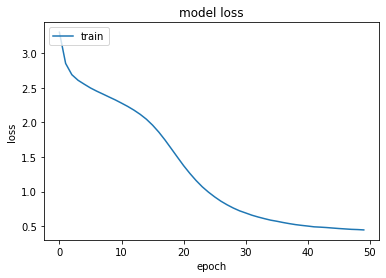

In [88]:
import matplotlib.pyplot as plt 
plt.plot(H.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
plt.show()

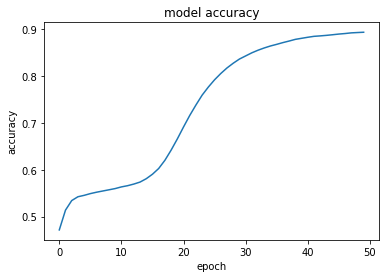

In [89]:
import matplotlib.pyplot as plt 
plt.plot(H.history['acc'])
# plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
plt.plot(H.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#Test

##Define

In [88]:
enc_model = tf.keras.models.Model(enc_inp, [encoder_outputs, enc_states])



In [89]:
enc_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 13)]              0         
                                                                 
 encoder (Encoder)           ((None, 13, 800),         1594600   
                              [(None, 800),                      
                              (None, 800)])                      
                                                                 
Total params: 1,594,600
Trainable params: 1,594,600
Non-trainable params: 0
_________________________________________________________________


In [90]:
encoder_outputs.shape

TensorShape([None, 13, 800])

In [91]:
decoder_state_input_h = tf.keras.layers.Input(shape=( 400 * 2,))
decoder_state_input_c = tf.keras.layers.Input(shape=( 400 * 2,))

decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_enc_output_inputs = tf.keras.layers.Input(shape=( len_seq, 400 * 2,))

decoder_outputs, attention_weights, decoder_states = decoder(
    dec_inp=dec_inp,
    enc_output=decoder_enc_output_inputs, 
    state=decoder_states_inputs
)


#decoder_output = dec_dense(decoder_outputs)

dec_model = tf.keras.models.Model([dec_inp, decoder_enc_output_inputs] + decoder_states_inputs,
                                      [decoder_outputs, attention_weights]+ decoder_states)

In [92]:
dec_model.compile(loss='categorical_crossentropy',metrics=['acc'],optimizer='adam')

In [93]:
dec_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 13)]         0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 13, 800)]    0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 800)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 800)]        0           []                               
                                                                                            

In [ ]:
dec_model.save('decoder_model.h5')
enc_model.save('encoder_model.h5')

##Inference

In [94]:
from keras.preprocessing.sequence import pad_sequences
print("##########################################")
print("#       start chatting ver. 1.0          #")
print("##########################################")


prepro1 = ""
while prepro1 != 'q':
    
    prepro1 = input("you : ")
    try:
        prepro1 = clean_text(prepro1)
        prepro = [prepro1]
        
        txt = []
        for x in prepro:
            lst = []
            for y in x.split():
                try:
                    lst.append(vocab[y])
                except:
                    lst.append(vocab['<OUT>'])
            txt.append(lst)
        txt = pad_sequences(txt, 13, padding='post')


        ###
        enc_op, stat = enc_model.predict( txt )

        # empty_target_seq = np.zeros( ( 1 , 1) )
        # empty_target_seq[0, 0] = vocab['<SOS>']

        start_index = vocab['<SOS>']
        empty_target_seq = tf.constant([[start_index]])
        stop_condition = False
        decoded_translation = ''


        while not stop_condition :

            dec_outputs , attention_weights, decoder_states_h, decoder_states_c = dec_model.predict([ empty_target_seq, enc_op ] + stat )

            ###
            ###########################
            # w1_query_op = W1(dec_outputs)
            # w2_key_op = W2(enc_op)

            # context_vector_op, attn_weight_op = attn_layer(
            #     [w1_query_op, enc_op, w2_key_op],
            #     return_attention_scores = True
            # )
            # decoder_concat_input = Concatenate(axis=-1)([context_vector_op, dec_outputs])
            # decoder_concat_input = Wc(decoder_concat_input)
            # decoder_concat_input = dec_dense(decoder_concat_input)
            ###########################

            sampled_word_index = np.argmax( dec_outputs[0, -1, :] )

            sampled_word = inv_vocab[sampled_word_index] + ' '

            if sampled_word != '<EOS> ':
                decoded_translation += sampled_word           


            if sampled_word == '<EOS> ' or len(decoded_translation.split()) > 13:
                stop_condition = True

            # empty_target_seq = np.zeros( ( 1 , 1 ) )  
            empty_target_seq = tf.constant([[sampled_word_index]])
            stat = [decoder_states_h, decoder_states_c]

        print("chatbot attention : ", decoded_translation )
        print("==============================================")

    except:
        print("sorry didn't got you , please type again :( ")

##########################################
#       start chatting ver. 1.0          #
##########################################
you : Hi
chatbot attention :  hi 
you : Hello
chatbot attention :  <OUT> 
you : Who are you
chatbot attention :  i am your son 
you : How could you be my son
chatbot attention :  <OUT> no other 
you : I have a daughter
chatbot attention :  you want a man you got a <OUT> you have a 
you : I love you son
chatbot attention :  yeah am you really bad 
you : I love you
chatbot attention :  i love you walter did anyone ever call you anything other 
you : Do you have a crush
chatbot attention :  no 
you : I have a crush
chatbot attention :  the <OUT> came to your house he is got a bit 
you : I have a crush that is you
chatbot attention :  you have a <OUT> you didnt have a hard choice your 
you : Do you want to sleep
chatbot attention :  no 
you : Good night
chatbot attention :  goodbye 
you : Good morning
chatbot attention :  i thought i would stay the night 
you : G

In [ ]:
with tf.keras.utils.custom_object_scope({'Decoder': Decoder}):
    new_dec = tf.keras.models.load_model('decoder_model.h5')

In [ ]:
with tf.keras.utils.custom_object_scope({'Encoder': Encoder}):
    new_enc = tf.keras.models.load_model('encoder_model.h5')


In [ ]:
from keras.preprocessing.sequence import pad_sequences
print("##########################################")
print("#       start chatting ver. 1.0          #")
print("##########################################")


prepro1 = ""
while prepro1 != 'q':
    
    prepro1 = input("you : ")
    try:
        prepro1 = clean_text(prepro1)
        prepro = [prepro1]
        
        txt = []
        for x in prepro:
            lst = []
            for y in x.split():
                try:
                    lst.append(vocab[y])
                except:
                    lst.append(vocab['<OUT>'])
            txt.append(lst)
        txt = pad_sequences(txt, 13, padding='post')


        ###
        enc_op, stat = new_enc.predict( txt )

        # empty_target_seq = np.zeros( ( 1 , 1) )
        # empty_target_seq[0, 0] = vocab['<SOS>']

        start_index = vocab['<SOS>']
        empty_target_seq = tf.constant([[start_index]])
        stop_condition = False
        decoded_translation = ''


        while not stop_condition :

            dec_outputs , attention_weights, decoder_states_h, decoder_states_c = new_dec.predict([ empty_target_seq, enc_op ] + stat )

            ###
            ###########################
            # w1_query_op = W1(dec_outputs)
            # w2_key_op = W2(enc_op)

            # context_vector_op, attn_weight_op = attn_layer(
            #     [w1_query_op, enc_op, w2_key_op],
            #     return_attention_scores = True
            # )
            # decoder_concat_input = Concatenate(axis=-1)([context_vector_op, dec_outputs])
            # decoder_concat_input = Wc(decoder_concat_input)
            # decoder_concat_input = dec_dense(decoder_concat_input)
            ###########################

            sampled_word_index = np.argmax( dec_outputs[0, -1, :] )

            sampled_word = inv_vocab[sampled_word_index] + ' '

            if sampled_word != '<EOS> ':
                decoded_translation += sampled_word           


            if sampled_word == '<EOS> ' or len(decoded_translation.split()) > 13:
                stop_condition = True

            # empty_target_seq = np.zeros( ( 1 , 1 ) )  
            empty_target_seq = tf.constant([[sampled_word_index]])
            stat = [decoder_states_h, decoder_states_c]

        print("chatbot attention : ", decoded_translation )
        print("==============================================")

    except:
        print("sorry didn't got you , please type again :( ")

##########################################
#       start chatting ver. 1.0          #
##########################################
you : hello


chatbot attention :  hi its me just who you wanted to talk to right 
you : how can you know
chatbot attention :  no 
you : Do you know
chatbot attention :  no 
you : I love you
chatbot attention :  i love you walter did anyone ever call you anything other 
you : I love you too
chatbot attention :  i love you dad i feel well i have to but 
you : I want to kiss you
chatbot attention :  edward that is okay 
you : hello
chatbot attention :  hi its me just who you wanted to talk to right 
you : what's your name?
chatbot attention :  the baby the hell theres a football program 
you : Your name
chatbot attention :  thomas kent i would like to do a speech by a 
you : Remember
chatbot attention :  no that was years ago i have lived years since then 
you : How old are you
chatbot attention :  17 
you : Bye never want to see you
chatbot attention :  i am <OUT> 
you : Bye forever
chatbot attention :  and thanks 
you : Bye
chatbot attention :  bye 
you : q
chatbot attention :  i am <OUT> 
